# Stitching Tutorial

The Workflow of the Stitching Pipeline can be seen in the following. Note that the image comes from the [OpenCV Documentation](https://docs.opencv.org/3.4/d1/d46/group__stitching.html).

![image stitching pipeline](https://github.com/opencv/opencv/blob/master/modules/stitching/doc/StitchingPipeline.jpg?raw=true)

With the following block, we allow displaying resulting images within the notebook:

In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np

def plot_image(img, figsize_in_inches=(5,5)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(5,5)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

With the following block, we load the correct img paths to the used image sets:

In [2]:
from pathlib import Path
def get_image_paths(img_set):
    return [str(path.relative_to('.')) for path in Path('imgs').rglob(f'{img_set}*')]

#weir_imgs = get_image_paths('weir')
weir_imgs = ['./imgs/labc1_2.jpg', './imgs/labc2_2.jpg','./imgs/labc3_2.jpg','./imgs/labc4_2.jpg']
print(weir_imgs)
# budapest_imgs = get_image_paths('buda')
# exposure_error_imgs = get_image_paths('exp')
# barcode_imgs = get_image_paths('barc')
# barcode_masks = get_image_paths('mask')

['./imgs/labc1_2.jpg', './imgs/labc2_2.jpg', './imgs/labc3_2.jpg', './imgs/labc4_2.jpg']


## Resize Images

The first step is to resize the images to medium (and later to low) resolution. The class which can be used is the `Images` class. If the images should not be stitched on full resolution, this can be achieved by setting the `final_megapix` parameter to a number above 0. 

`Images.of(images, medium_megapix=0.6, low_megapix=0.1, final_megapix=-1)`

In [3]:
from stitching.images import Images

images = Images.of(weir_imgs)
print()

medium_imgs = list(images.resize(Images.Resolution.MEDIUM))
low_imgs = list(images.resize(Images.Resolution.LOW))
final_imgs = list(images.resize(Images.Resolution.FINAL))

**NOTE:** Everytime `list()` is called in this notebook means that the function returns a generator (generators improve the overall stitching performance). To get all elements at once we use `list(generator_object)`  

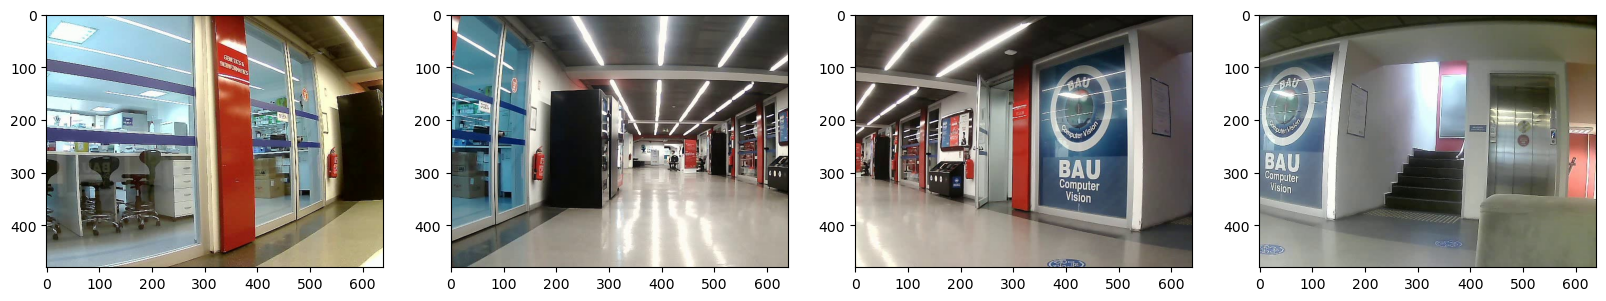

In [4]:
plot_images(medium_imgs, (20,20))

In [5]:
original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

print(f"Original Size: {original_size}  -> {'{:,}'.format(np.prod(original_size))} px ~ 1 MP")
print(f"Medium Size:   {medium_size}  -> {'{:,}'.format(np.prod(medium_size))} px ~ 0.6 MP")
print(f"Low Size:      {low_size}   -> {'{:,}'.format(np.prod(low_size))} px ~ 0.1 MP")
print(f"Final Size:    {final_size}  -> {'{:,}'.format(np.prod(final_size))} px ~ 1 MP")

Original Size: (640, 480)  -> 307,200 px ~ 1 MP
Medium Size:   (640, 480)  -> 307,200 px ~ 0.6 MP
Low Size:      (365, 274)   -> 100,010 px ~ 0.1 MP
Final Size:    (640, 480)  -> 307,200 px ~ 1 MP


## Find Features

On the medium images, we now want to find features that can describe conspicuous elements within the images which might be found in other images as well. The class which can be used is the `FeatureDetector` class.

`FeatureDetector(detector='orb', nfeatures=500)`

In [7]:
def process(img):
    original_img=img
    median_blur = cv.medianBlur(original_img, 3)
    gray_img = cv.cvtColor(median_blur, cv.COLOR_BGR2GRAY)
    return gray_img


from stitching.feature_detector import FeatureDetector

finder = FeatureDetector(detector='brisk')
pre_process_img=[process(img) for img in medium_imgs]
features = [finder.detect_features(img) for img in pre_process_img]
keypoints_center_img = finder.draw_keypoints(pre_process_img[0], features[0])

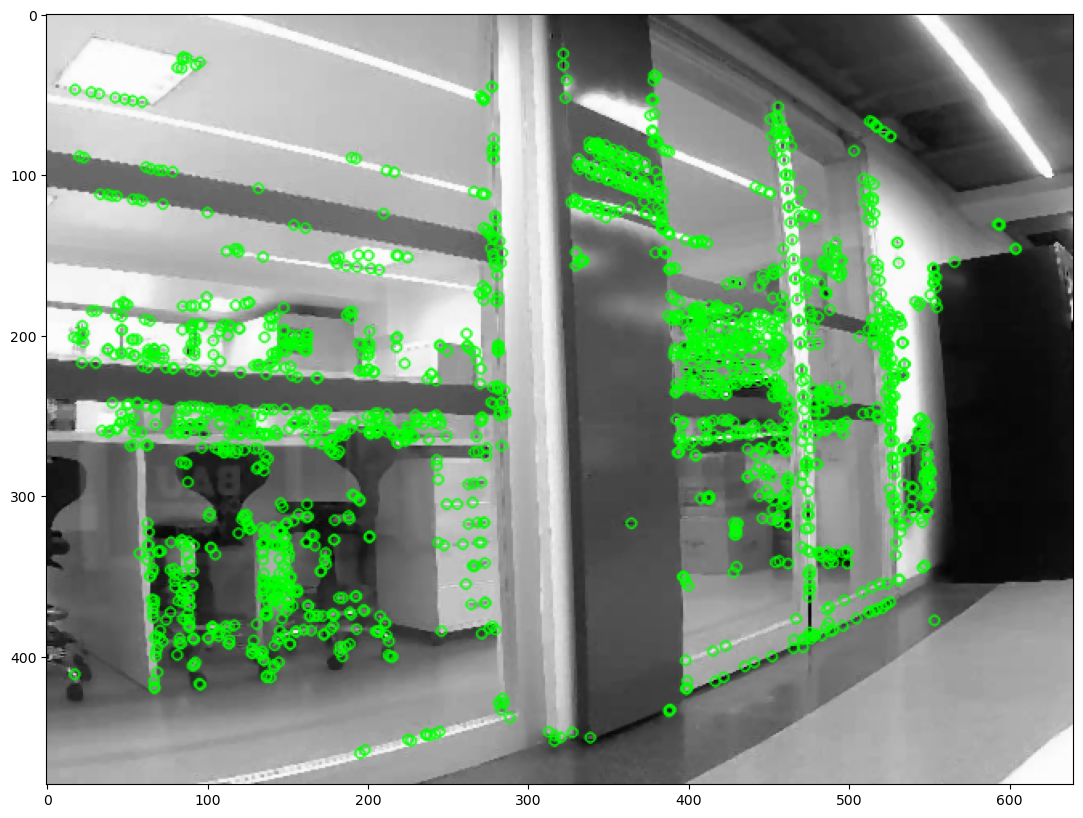

In [9]:
plot_image(keypoints_center_img, (15,10))

## Match Features

Now we can match the features of the pairwise images. The class which can be used is the FeatureMatcher class.

`FeatureMatcher(matcher_type='homography', range_width=-1)`

In [8]:
from stitching.feature_matcher import FeatureMatcher

matcher = FeatureMatcher()
matches = matcher.match_features(features)

We can look at the confidences, which are calculated by:

`confidence = number of inliers / (8 + 0.3 * number of matches)` (Lines 435-7 of [this file](https://github.com/opencv/opencv/blob/68d15fc62edad980f1ffa15ee478438335f39cc3/modules/stitching/src/matchers.cpp))

The inliers are calculated using the random sample consensus (RANSAC) method, e.g. in [this file](https://github.com/opencv/opencv/blob/68d15fc62edad980f1ffa15ee478438335f39cc3/modules/stitching/src/matchers.cpp) in Line 425. We can plot the inliers which is shown later.

In [9]:
matcher.get_confidence_matrix(matches)

array([[0.        , 1.16455696, 0.42016807, 0.49180328],
       [1.16455696, 0.        , 2.08459215, 0.37383178],
       [0.42016807, 2.08459215, 0.        , 1.50515464],
       [0.49180328, 0.37383178, 1.50515464, 0.        ]])

It can be seen that:

- image 1 has a high matching confidence with image 2 and low confidences with image 3 and 4
- image 2 has a high matching confidence with image 1 and image 3 and low confidences with image 4
- image 3 has a high matching confidence with image 2 and low confidences with image 1 and 4
- image 4 has low matching confidences with image 1, 2 and 3

With a `confidence_threshold`, which is introduced in detail in the next step, we can plot the relevant matches with the inliers:

Matches Image 1 to Image 2


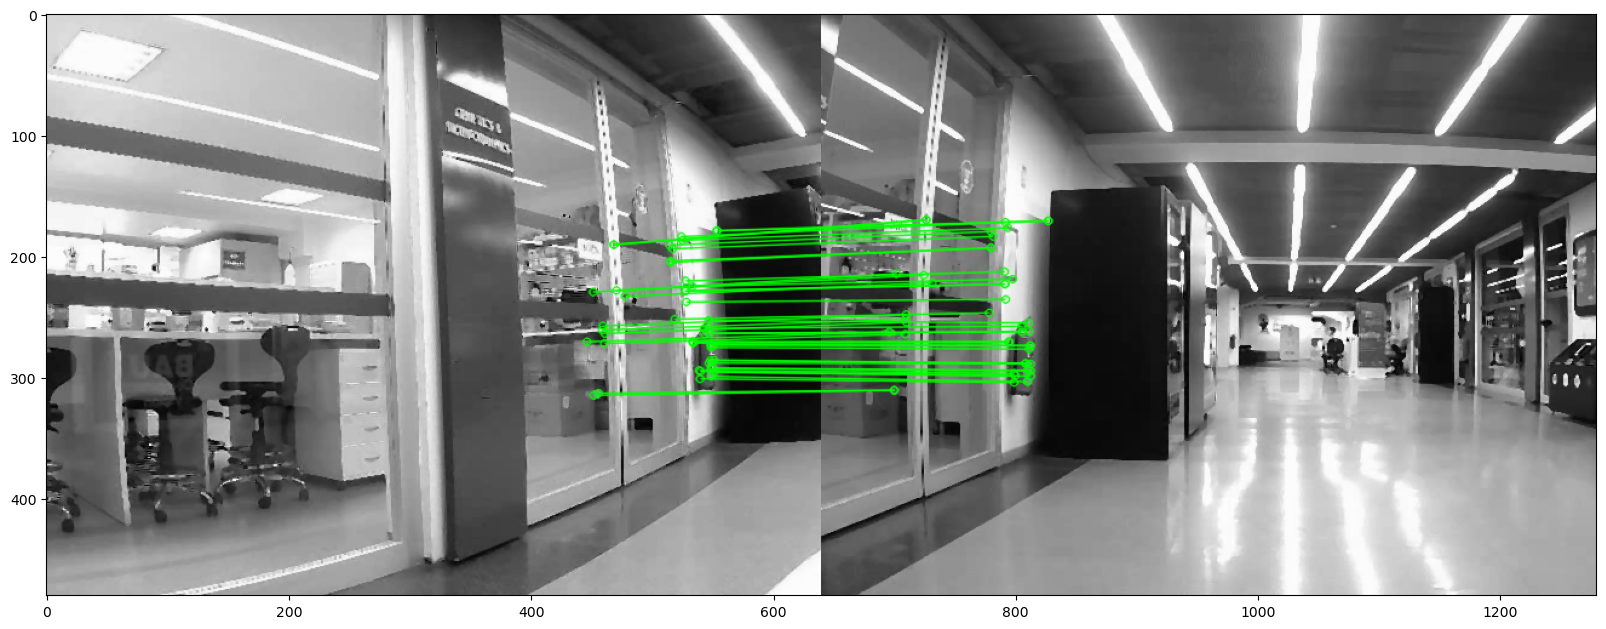

Matches Image 2 to Image 3


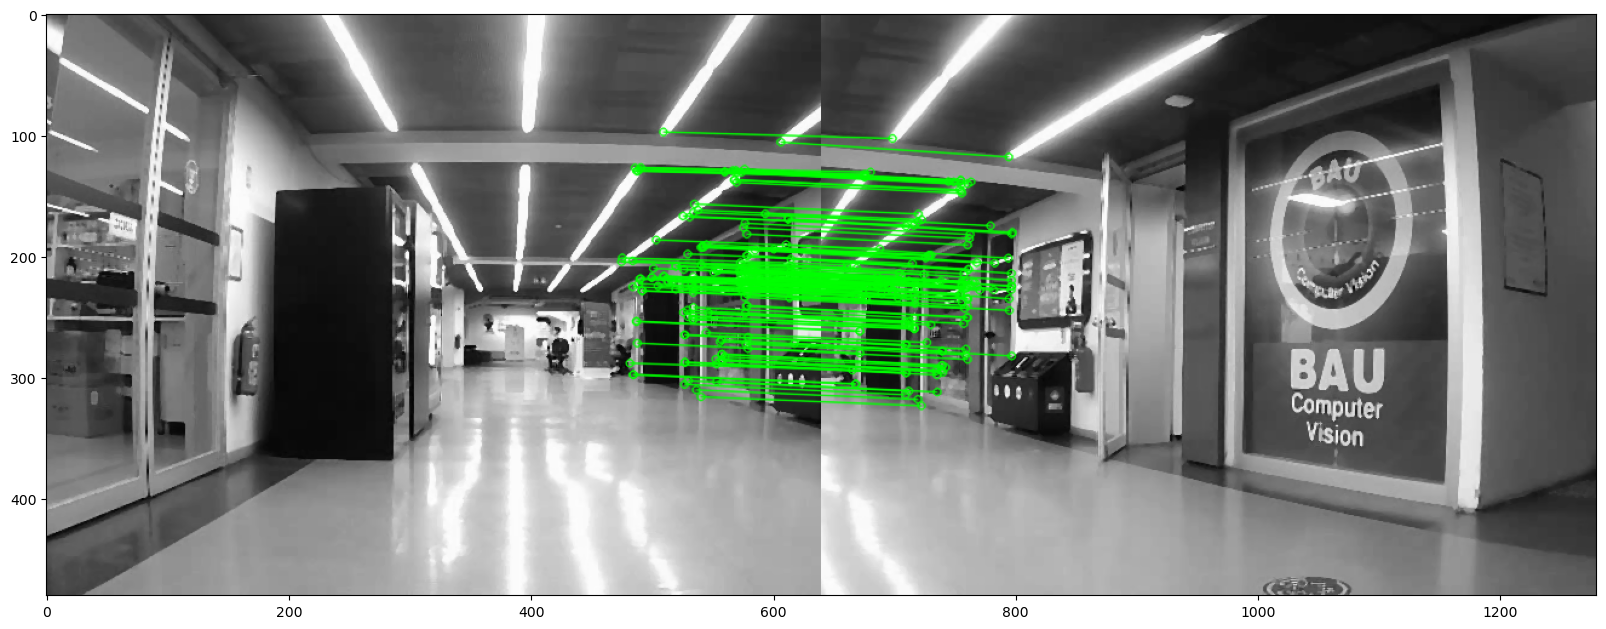

Matches Image 3 to Image 4


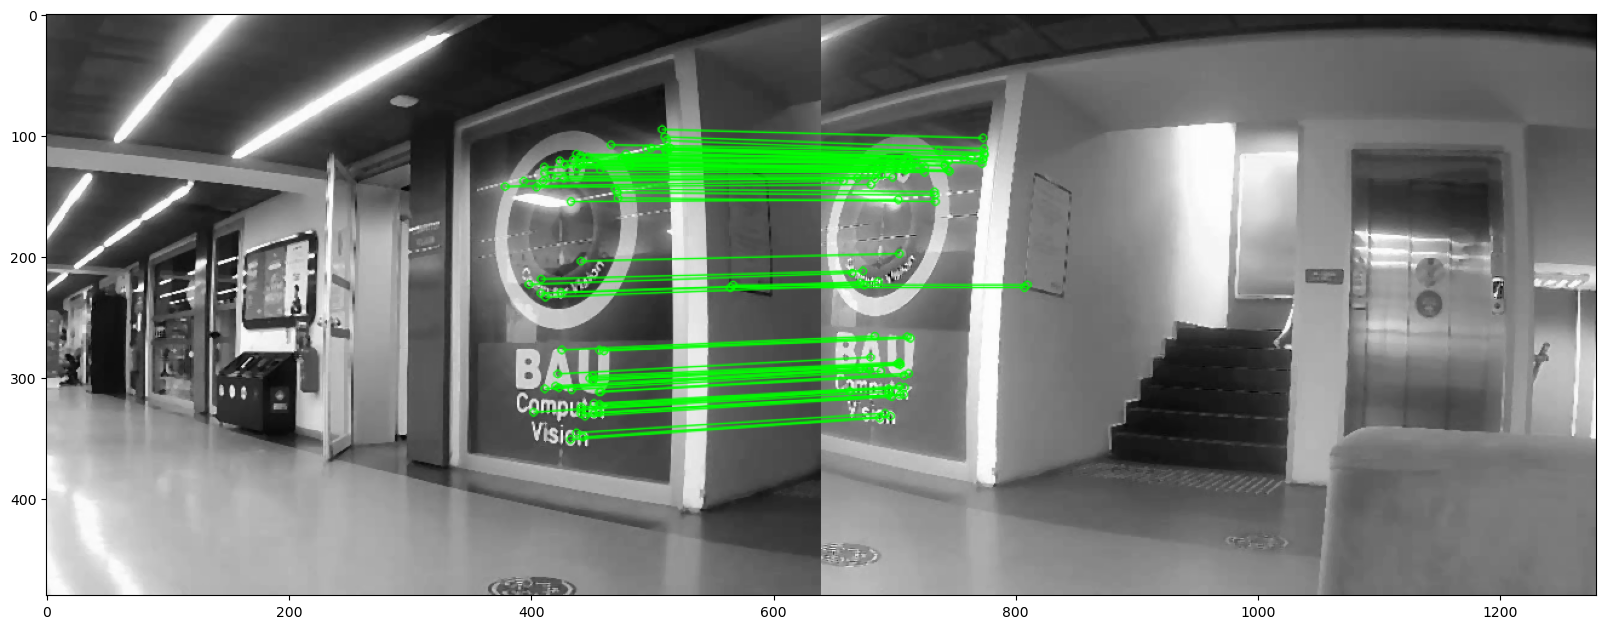

In [10]:
all_relevant_matches = matcher.draw_matches_matrix(pre_process_img, features, matches, conf_thresh=0.7, 
                                                   inliers=True, matchColor=(0, 255, 0))

for idx1, idx2, img in all_relevant_matches:
    print(f"Matches Image {idx1+1} to Image {idx2+1}")
    plot_image(img, (20,10))

## Subset

Above we saw that the noise image has no connection to the other images which are part of the panorama. We now want to create a subset with only the relevant images. The class which can be used is the `Subsetter` class. We can specify the `confidence_threshold` from when a match is regarded as good match. We saw that in our case `1` is sufficient. For the parameter `matches_graph_dot_file` a file name can be passed, in which a matches graph in dot notation is saved. 

`Subsetter(confidence_threshold=1, matches_graph_dot_file=None)`

In [11]:
from stitching.subsetter import Subsetter

subsetter = Subsetter(confidence_threshold=1, matches_graph_dot_file=None)
dot_notation = subsetter.get_matches_graph(images.names, matches)
print(dot_notation)

graph matches_graph{
"labc1_2.jpg" -- "labc2_2.jpg"[label="Nm=105, Ni=46, C=1.16456"];
"labc2_2.jpg" -- "labc3_2.jpg"[label="Nm=194, Ni=138, C=2.08459"];
"labc3_2.jpg" -- "labc4_2.jpg"[label="Nm=135, Ni=73, C=1.50515"];
}


In [12]:
indices = subsetter.get_indices_to_keep(features, matches)

medium_imgs = subsetter.subset_list(medium_imgs, indices)
low_imgs = subsetter.subset_list(low_imgs, indices)
final_imgs = subsetter.subset_list(final_imgs, indices)
features = subsetter.subset_list(features, indices)
matches = subsetter.subset_matches(matches, indices)

images.subset(indices)

print(images.names)
print(matcher.get_confidence_matrix(matches))

['./imgs/labc1_2.jpg', './imgs/labc2_2.jpg', './imgs/labc3_2.jpg', './imgs/labc4_2.jpg']
[[0.         1.16455696 0.42016807 0.49180328]
 [1.16455696 0.         2.08459215 0.37383178]
 [0.42016807 2.08459215 0.         1.50515464]
 [0.49180328 0.37383178 1.50515464 0.        ]]


## Camera Estimation, Adjustion and Correction

With the features and matches we now want to calibrate cameras which can be used to warp the images so they can be composed correctly. The classes which can be used are `CameraEstimator`, `CameraAdjuster` and `WaveCorrector`:

```
CameraEstimator(estimator='homography')
CameraAdjuster(adjuster='ray', refinement_mask='xxxxx')
WaveCorrector(wave_correct_kind='horiz')
```

In [13]:
from stitching.camera_estimator import CameraEstimator
from stitching.camera_adjuster import CameraAdjuster
from stitching.camera_wave_corrector import WaveCorrector

camera_estimator = CameraEstimator(estimator='homography')
camera_adjuster = CameraAdjuster()
wave_corrector = WaveCorrector()

cameras = camera_estimator.estimate(features, matches)
cameras = camera_adjuster.adjust(features, matches, cameras)
cameras = wave_corrector.correct(cameras)

## Warp Images

With the obtained cameras we now want to warp the images itself into the final plane. The class which can be used is the `Warper` class:

`Warper(warper_type='spherical', scale=1)`

In [14]:
from stitching.warper import Warper

warper = Warper()

At first, we set the the medium focal length of the cameras as scale:

In [15]:
warper.set_scale(cameras)

Warp low resolution images

In [25]:
low_sizes = images.get_scaled_img_sizes(Images.Resolution.LOW)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.LOW)  # since cameras were obtained on medium imgs

warped_low_imgs = list(warper.warp_images(low_imgs, cameras, camera_aspect))
warped_low_masks = list(warper.create_and_warp_masks(low_sizes, cameras, camera_aspect))
low_corners, low_sizes = warper.warp_rois(low_sizes, cameras, camera_aspect)

print(low_sizes)
print(camera_aspect)
print(low_corners)

[(432, 299), (376, 264), (379, 266), (420, 291)]
0.570544330734548
[(-578, 1445), (-322, 1466), (-57, 1460), (153, 1450)]


Warp final resolution images

In [21]:
final_sizes = images.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

print(final_size,camera_aspect)

(640, 480) 1.0


We can plot the results. Not much scaling and rotating is needed to align the images. Thus, the images are only slightly adjusted in this example 

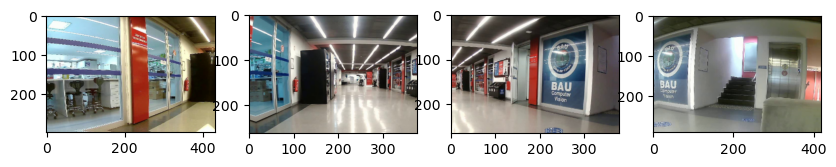

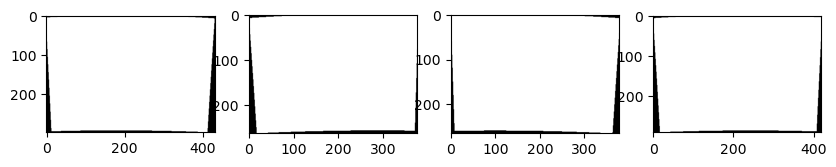

In [26]:
plot_images(warped_low_imgs, (10,10))
plot_images(warped_low_masks, (10,10))

With the warped corners and sizes we know where the images will be placed on the final plane:

In [27]:
print(final_corners)
print(final_sizes)

[(-1014, 2533), (-564, 2569), (-100, 2559), (268, 2541)]
[(758, 524), (660, 464), (666, 467), (737, 510)]


## Excursion: Timelapser

The Timelapser functionality is a nice way to grasp how the images are warped into a final plane. The class which can be used is the `Timelapser` class:

`Timelapser(timelapse='no')`

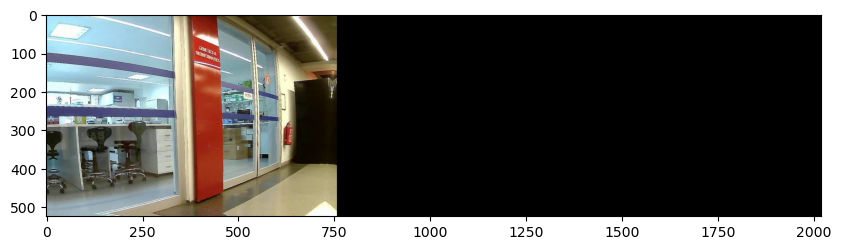

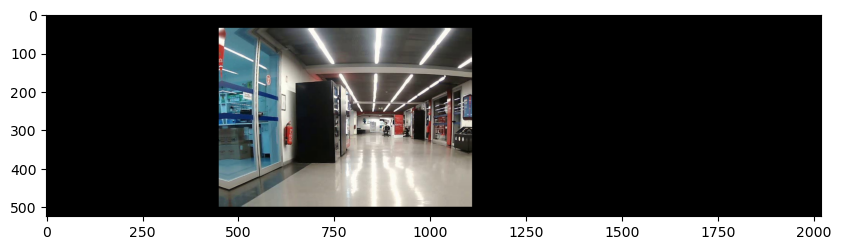

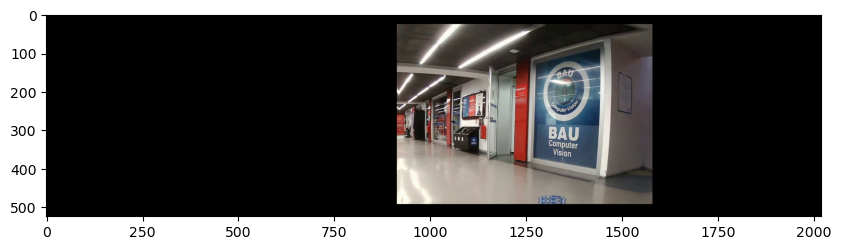

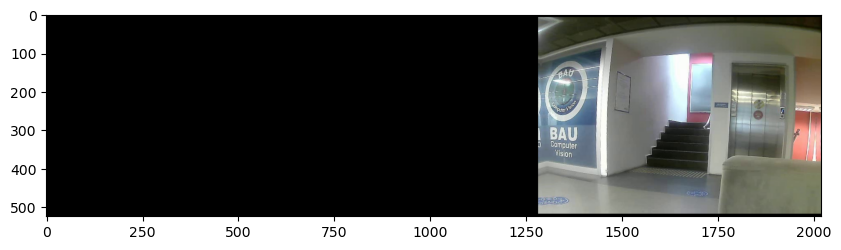

In [22]:
from stitching.timelapser import Timelapser

timelapser = Timelapser('as_is')
timelapser.initialize(final_corners, final_sizes)

for img, corner in zip(warped_final_imgs, final_corners):
    timelapser.process_frame(img, corner)
    frame = timelapser.get_frame()
    plot_image(frame, (10,10))

## Crop

We can see that none of the images have the full height of the final plane. To get a panorama without black borders we can now estimate the largest joint interior rectangle and crop the single images accordingly. The class which can be used is the `Cropper` class:

`Cropper(crop=True)`

In [28]:
from stitching.cropper import Cropper

cropper = Cropper()

We can estimate a panorama mask of the potential final panorama (using a Blender which will be introduced later)

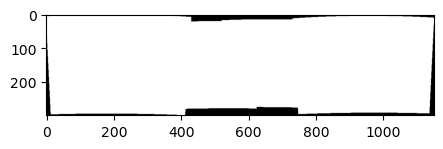

In [29]:
mask = cropper.estimate_panorama_mask(warped_low_imgs, warped_low_masks, low_corners, low_sizes)
plot_image(mask, (5,5))

The estimation of the largest interior rectangle is not yet implemented in OpenCV, but a [Numba](https://numba.pydata.org/) Implementation by my own. You check out the details [here](https://github.com/lukasalexanderweber/lir). Compiling the Code takes a bit (only once, the compiled code is then [cached](https://numba.pydata.org/numba-doc/latest/developer/caching.html) for future function calls)

In [30]:
lir = cropper.estimate_largest_interior_rectangle(mask)

After compilation the estimation is really fast:

In [31]:
lir = cropper.estimate_largest_interior_rectangle(mask)
print(lir)

Rectangle(x=13, y=22, width=1126, height=253)


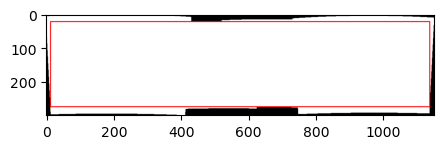

In [32]:
plot = lir.draw_on(mask, size=2)
plot_image(plot, (5,5))

By zero centering the the warped corners, the rectangle of the images within the final plane can be determined. Here the center image is shown:

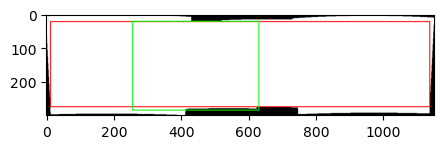

In [33]:
low_corners = cropper.get_zero_center_corners(low_corners)
rectangles = cropper.get_rectangles(low_corners, low_sizes)

plot = rectangles[1].draw_on(plot, (0, 255, 0), 2)  # The rectangle of the center img
plot_image(plot, (5,5))

Using the overlap new corners and sizes can be determined:

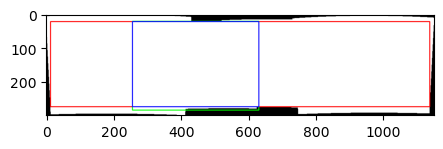

In [34]:
overlap = cropper.get_overlap(rectangles[1], lir)
plot = overlap.draw_on(plot, (255, 0, 0), 2)
plot_image(plot, (5,5))

With the blue Rectangle in the coordinate system of the original image (green) we are able to crop it

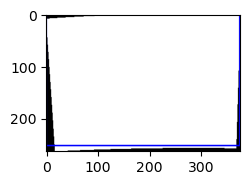

In [35]:
intersection = cropper.get_intersection(rectangles[1], overlap)
plot = intersection.draw_on(warped_low_masks[1], (255, 0, 0), 2)
plot_image(plot, (2.5,2.5))

Using all this information we can crop the images and masks and obtain new corners and sizes

In [36]:
cropper.prepare(warped_low_imgs, warped_low_masks, low_corners, low_sizes)

cropped_low_masks = list(cropper.crop_images(warped_low_masks))
cropped_low_imgs = list(cropper.crop_images(warped_low_imgs))
low_corners, low_sizes = cropper.crop_rois(low_corners, low_sizes)

lir_aspect = images.get_ratio(Images.Resolution.LOW, Images.Resolution.FINAL)  # since lir was obtained on low imgs
cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

Redo the timelapse with cropped Images:

In [37]:
timelapser = Timelapser('as_is')
timelapser.initialize(final_corners, final_sizes)

for img, corner in zip(cropped_final_imgs, final_corners):
    timelapser.process_frame(img, corner)
    frame = timelapser.get_frame()
    plot_image(frame, (10,10))

NameError: name 'Timelapser' is not defined

Now we need stategies how to compose the already overlaying images into one panorama image. Strategies are:

- Seam Masks
- Exposure Error Compensation
- Blending

## Seam Masks

Seam masks find a transition line between images with the least amount of interference. The class which can be used is the `SeamFinder` class:

`SeamFinder(finder='dp_color')`

The Seams are obtained on the warped low resolution images and then resized to the warped final resolution images. The Seam Masks can be used in the Blending step to specify how the images should be composed.

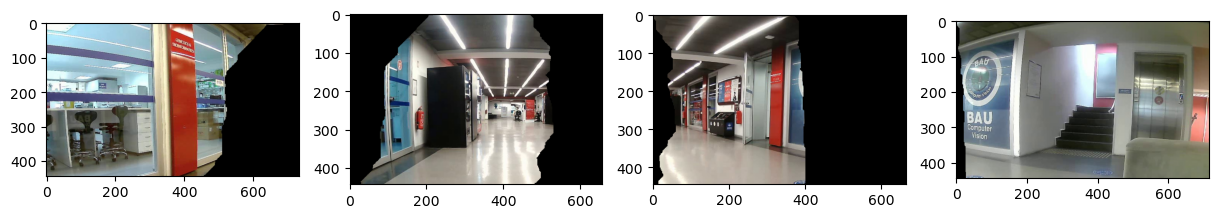

In [38]:
from stitching.seam_finder import SeamFinder

seam_finder = SeamFinder()

seam_masks = seam_finder.find(cropped_low_imgs, low_corners, cropped_low_masks)
seam_masks = [seam_finder.resize(seam_mask, mask) for seam_mask, mask in zip(seam_masks, cropped_final_masks)]

seam_masks_plots = [SeamFinder.draw_seam_mask(img, seam_mask) for img, seam_mask in zip(cropped_final_imgs, seam_masks)]
plot_images(seam_masks_plots, (15,10))

## Exposure Error Compensation

Frequently exposure errors respectively exposure differences between images occur which lead to artefacts in the final panorama. The class which can be used is the `ExposureErrorCompensator` class:

`ExposureErrorCompensator(compensator='gain_blocks', nr_feeds=1, block_size=32)`

The Exposure Error are estimated on the warped low resolution images and then applied on the warped final resolution images.

**Note:** In this example the compensation has nearly no effect and the result is not shown. To understand the stitching pipeline they are compensated anyway. A fitting example for images where Exposure Error Compensation is important can be found at the end of the notebook.   

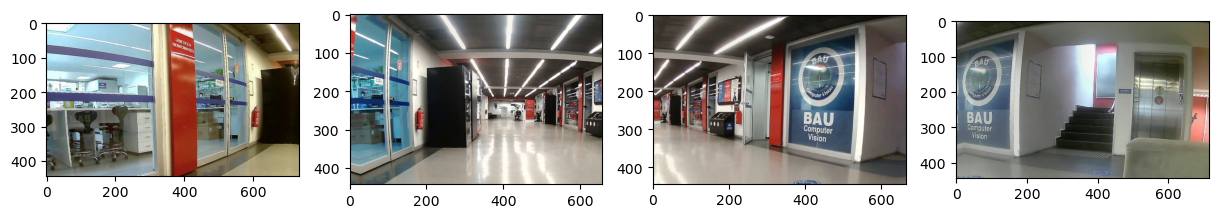

In [39]:
from stitching.exposure_error_compensator import ExposureErrorCompensator

compensator = ExposureErrorCompensator()

compensator.feed(low_corners, cropped_low_imgs, cropped_low_masks)

compensated_imgs = [compensator.apply(idx, corner, img, mask) 
                    for idx, (img, mask, corner) 
                    in enumerate(zip(cropped_final_imgs, cropped_final_masks, final_corners))]
plot_images(compensated_imgs,(15,10))

## Blending

With all the previous processing the images can finally be blended to a whole panorama. The class which can be used is the `Blender` class:

`Blender(blender_type='multiband', blend_strength=5)`

The blend strength thereby specifies on which overlap the images should be overlayed along the transitions of the masks. This is also visualized at the end of the notebook.

In [40]:
from stitching.blender import Blender

blender = Blender()
blender.prepare(final_corners, final_sizes)
for img, mask, corner in zip(compensated_imgs, seam_masks, final_corners):
    blender.feed(img, mask, corner)
panorama, _ = blender.blend()

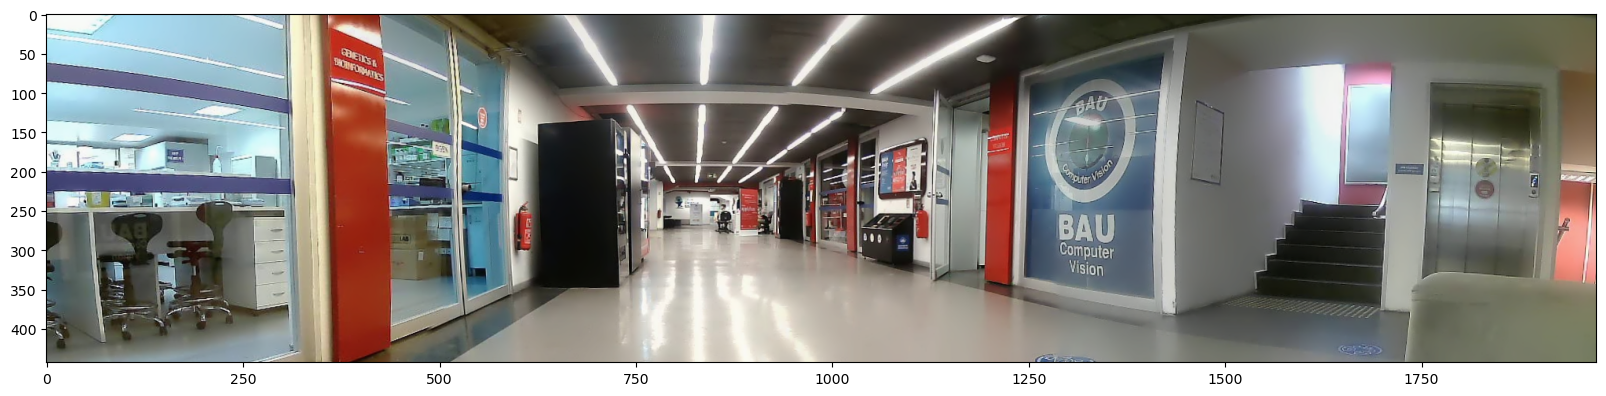

In [36]:
plot_image(panorama, (20,20))

There is the functionality to plot the seams as lines or polygons onto the final panorama to see which part of the panorama is from which image. The basis is to blend single colored dummy images with the obtained seam masks and panorama dimensions:

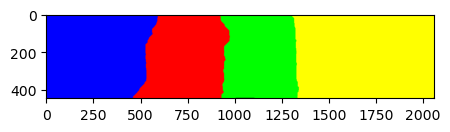

In [677]:
blended_seam_masks = seam_finder.blend_seam_masks(seam_masks, final_corners, final_sizes)
plot_image(blended_seam_masks, (5,5))

This blend can be converted into lines or weighted on top of the resulting panorama:

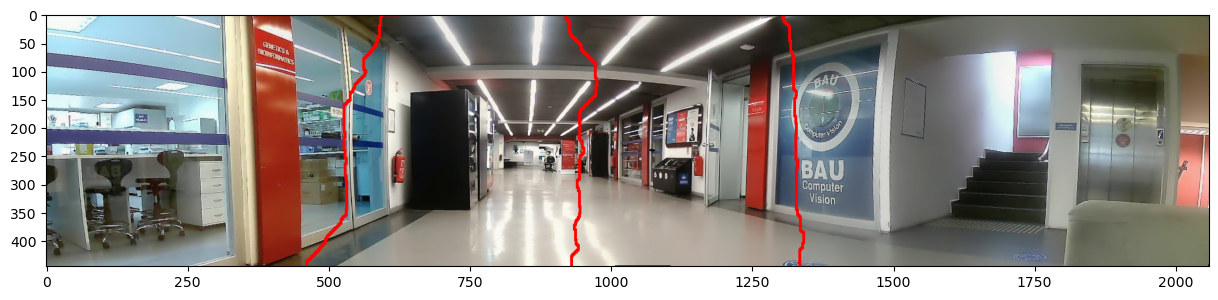

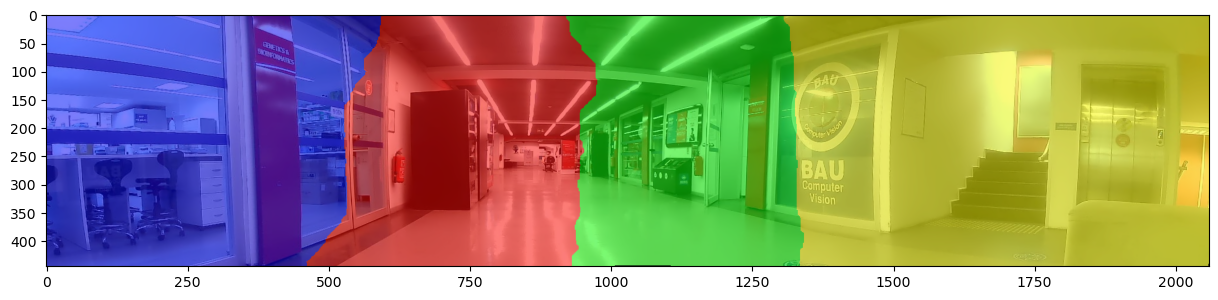

In [678]:
plot_image(seam_finder.draw_seam_lines(panorama, blended_seam_masks, linesize=3), (15,10))
plot_image(seam_finder.draw_seam_polygons(panorama, blended_seam_masks), (15,10))

# Stitcher

All the functionality above is automated within the `Stitcher` class:

`Stitcher(**kwargs)`

In [39]:
from stitching import Stitcher

stitcher = Stitcher()
panorama = stitcher.stitch(weir_imgs)  # the user is warned that only a subset of input images is stitched

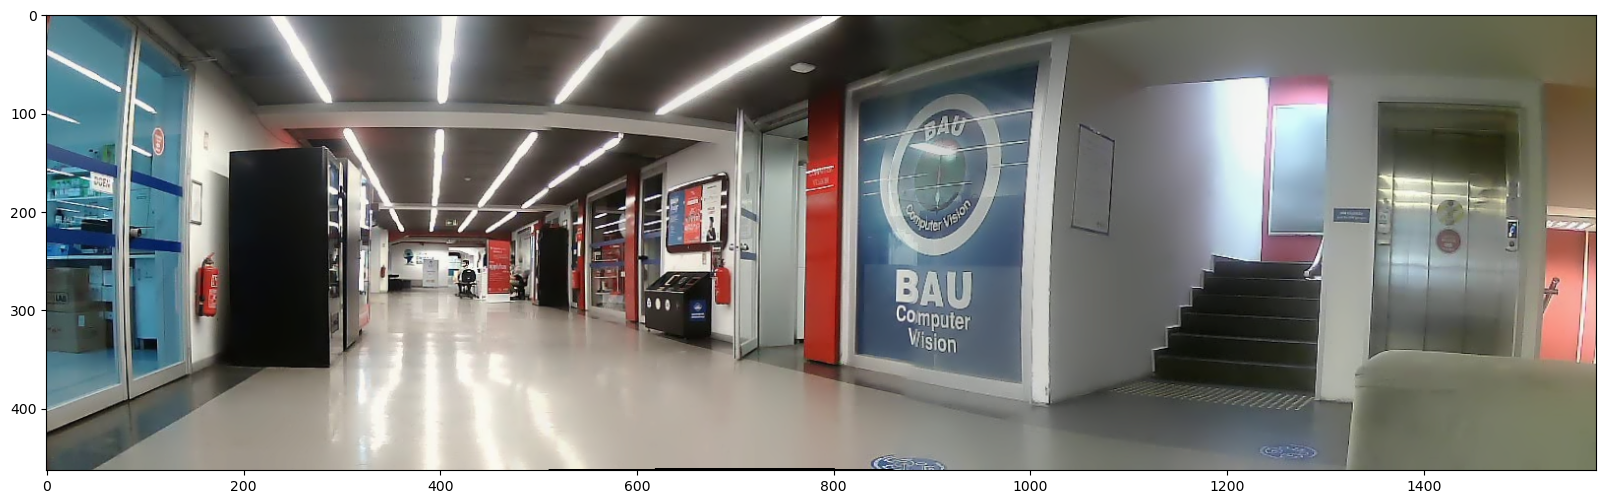

In [38]:
plot_image(panorama, (20,20))

## Affine Stitcher

For images that were obtained on e.g. a flatbed scanner affine transformations are sufficient. The `AffineStitcher` convenience class sets the needed parameters as default:

`AffineStitcher(**kwargs)`

In [681]:
from stitching import AffineStitcher

print(AffineStitcher.AFFINE_DEFAULTS)
# Comparison:
# print(Stitcher.DEFAULT_SETTINGS)
# print(AffineStitcher.DEFAULT_SETTINGS)

{'estimator': 'affine', 'wave_correct_kind': 'no', 'matcher_type': 'affine', 'adjuster': 'affine', 'warper_type': 'affine', 'compensator': 'no'}


We can now process the Budapest example (with two additional parameters)

In [682]:
settings = {# The whole plan should be considered
            "crop": False,
            # The matches confidences aren't that good
            "confidence_threshold": 0.5}    

stitcher = AffineStitcher(**settings)
panorama = stitcher.stitch(budapest_imgs)

plot_image(panorama, (20,20))

NameError: name 'budapest_imgs' is not defined

## Exposure Error and Blend Strenght Example

In [ ]:
imgs = exposure_error_imgs

stitcher = Stitcher(compensator="no", blender_type="no")
panorama1 = stitcher.stitch(imgs)

stitcher = Stitcher(compensator="no")
panorama2 = stitcher.stitch(imgs)

stitcher = Stitcher(compensator="no", blend_strength=20)
panorama3 = stitcher.stitch(imgs)

stitcher = Stitcher(blender_type="no")
panorama4 = stitcher.stitch(imgs)

stitcher = Stitcher(blend_strength=20)
panorama5 = stitcher.stitch(imgs)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
axs[0, 0].imshow(cv.cvtColor(panorama1, cv.COLOR_BGR2RGB))
axs[0, 0].set_title('Along Seam Masks with Exposure Errors')
axs[0, 1].axis('off')
axs[1, 0].imshow(cv.cvtColor(panorama2, cv.COLOR_BGR2RGB))
axs[1, 0].set_title('Blended with the default blend strenght of 5')
axs[1, 1].imshow(cv.cvtColor(panorama3, cv.COLOR_BGR2RGB))
axs[1, 1].set_title('Blended with a bigger blend strenght of 20')
axs[2, 0].imshow(cv.cvtColor(panorama4, cv.COLOR_BGR2RGB))
axs[2, 0].set_title('Along Seam Masks with Exposure Error Compensation')
axs[2, 1].imshow(cv.cvtColor(panorama5, cv.COLOR_BGR2RGB))
axs[2, 1].set_title('Blended with Exposure Compensation and bigger blend strenght of 20')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Feature Masking

Sometimes specific parts of your images disrupt the stitching workflow or you only want to match at specific parts of your images. See e.g. how the QR-Code manipulates the stitching:

In [ ]:
stitcher = Stitcher(crop=False)
panorama = stitcher.stitch(barcode_imgs)

plot_image(panorama, (20,20))

With the feature masks you can exclude the QR-Code areas of your images from feature detection and matching:

In [ ]:
stitcher = Stitcher()
panorama = stitcher.stitch(barcode_imgs, barcode_masks)

plot_image(panorama, (20,20))

See the [Pull Request](https://github.com/OpenStitching/stitching/pull/130) for more detailed intermediate images